In [1]:
%load_ext autoreload
%autoreload 2

Import required Libraries

In [2]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from kneed import KneeLocator
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import sys

In [3]:
import warnings
warnings.filterwarnings('ignore')

Import modules

In [4]:
sys.path.append(os.path.abspath(os.path.join('../scripts')))
from preprocessing import PreProcess
from overview import Overview
from plot import Plot
from logger import Logger

In [5]:
# Initialize logger
logger = Logger("userEngagement.log").get_app_logger()
logger.info("Initialized userEngagement.py logger")

Import the Data

In [6]:
#reading the cleaned data in EDA
df_org = pd.read_csv("C:\\Users\\1221\\Desktop\\Telecommunication-Data\\data\\cleaned telecom data.csv")

In [7]:
df = df_org.copy()

In [8]:
pl = Plot()
overview = Overview(df)

Data overview

In [9]:
df.head()

,Bearer Id,Start,Start ms,End,End ms,IMSI,MSISDN/Number,IMEI,Last Location Name,Avg RTT DL (ms),...,Other UL (Bytes),Total UL (Bytes),Total DL (Bytes),Avg Bearer TP DL (Bytes/s),Avg Bearer TP UL (Bytes/s),Dur. (s),Activity Duration DL (s),Activity Duration UL (s),RTT,TCP retransmission
0,1.031305,4/28/2019 2:43,-1.192254,4/29/2019 4:03,-0.908588,-0.055039,-0.002510,-0.582247,L74543C,-0.135939,...,0.924968,0.575116,-1.706642,-0.556274,-0.373847,-0.168122,-0.319267,-0.299392,-3.005272e-01,0.000000
1,-0.964193,4/28/2019 2:43,0.193611,4/29/2019 10:09,-0.381025,0.013799,-0.002509,-0.581318,T79696B,0.000000,...,-1.679514,-0.476903,-0.244959,-0.557894,-0.382889,0.102771,-0.322928,-0.304971,4.613194e-17,0.000000
2,-0.989136,4/28/2019 2:43,1.194898,4/29/2019 2:43,1.153073,0.001275,-0.002636,1.696797,T77477B,-0.039100,...,-0.931460,-0.902833,0.214852,0.586901,1.448078,-0.227911,1.663305,1.797104,-2.189841e-02,-0.053624
3,1.006361,4/28/2019 2:43,-0.582474,4/29/2019 2:43,-0.797522,0.004962,-0.002506,1.696797,T77530B,-0.072621,...,0.017814,0.569101,0.313547,0.194945,0.193850,-0.227911,0.841131,1.000126,6.587547e-01,-0.182074
4,1.031305,4/28/2019 2:43,1.250333,4/29/2019 6:18,-1.703404,-0.090185,-0.002624,-0.559024,L11222C,0.000000,...,-1.568276,-1.538527,1.672006,-0.557188,-0.375354,-0.068601,-0.320186,-0.301142,4.613194e-17,0.000000


User Engagement Analysis

Total data volume (in Bytes) during this session for each application

In [10]:
df["social_media"] = df["Social Media DL (Bytes)"] + df['Social Media UL (Bytes)']
df["google"] = df["Google DL (Bytes)"] + df["Google UL (Bytes)"]
df['email'] = df["Email DL (Bytes)"] + df["Email UL (Bytes)"]
df['youtube'] = df["Youtube DL (Bytes)"] + df["Youtube UL (Bytes)"]
df['netflix'] = df["Netflix DL (Bytes)"] + df["Netflix UL (Bytes)"]
df["gaming"] = df["Gaming DL (Bytes)"] + df["Gaming UL (Bytes)"]
df['other'] = df["Other DL (Bytes)"]+df["Other UL (Bytes)"]
df['total_data'] = df['Total DL (Bytes)'] + df['Total UL (Bytes)']

In [11]:
df.columns

Index(['Bearer Id', 'Start', 'Start ms', 'End', 'End ms', 'IMSI',
       'MSISDN/Number', 'IMEI', 'Last Location Name', 'Avg RTT DL (ms)',
       'Avg RTT UL (ms)', 'TCP DL Retrans. Vol (Bytes)',
       'TCP UL Retrans. Vol (Bytes)', 'DL TP < 50 Kbps (%)',
       '50 Kbps < DL TP < 250 Kbps (%)', '250 Kbps < DL TP < 1 Mbps (%)',
       'DL TP > 1 Mbps (%)', 'UL TP < 10 Kbps (%)',
       '10 Kbps < UL TP < 50 Kbps (%)', '50 Kbps < UL TP < 300 Kbps (%)',
       'UL TP > 300 Kbps (%)', 'HTTP DL (Bytes)', 'HTTP UL (Bytes)',
       'Dur. (ms).1', 'Handset Manufacturer', 'Handset Type',
       'Nb of sec with 125000B < Vol DL',
       'Nb of sec with 1250B < Vol UL < 6250B',
       'Nb of sec with 31250B < Vol DL < 125000B',
       'Nb of sec with 37500B < Vol UL',
       'Nb of sec with 6250B < Vol DL < 31250B',
       'Nb of sec with 6250B < Vol UL < 37500B',
       'Nb of sec with Vol DL < 6250B', 'Nb of sec with Vol UL < 1250B',
       'Social Media DL (Bytes)', 'Social Media UL (Bytes)'

Aggregate the number of session durations, total session duration, & total data for each user

In [12]:
df = df.rename( columns={'Bearer Id': 'sessions'})

In [13]:
user_engagement = df.groupby('MSISDN/Number').agg({'sessions': 'count', 'Dur. (ms).1': 'sum', 'total_data': 'sum'})

In [14]:
user_engagement.head()

,sessions,Dur. (ms).1,total_data
MSISDN/Number,,,
-0.002692,1,0.146799,1.139608
-0.002692,1,0.944041,-1.812243
-0.002692,1,0.372328,0.256948
-0.002692,1,-0.679254,-2.059544
-0.002692,2,-2.132773,2.926302


2.1 Users data analysis
Get the top 10 users with the highest total data volume, sessions, & session duration

Aggregate the above metrics per customer id (MSISDN) and report the top 10 customers per engagement metric

In [15]:
user_engagement.shape

(106294, 3)

In [16]:
sessions = user_engagement.nlargest(10, "sessions")['sessions']
duration = user_engagement.nlargest(10, "Dur. (ms).1")['Dur. (ms).1']
total_data = user_engagement.nlargest(10, "total_data")['total_data']

In [17]:
sesssions_df = pd.DataFrame()
sesssions_df['User_ID'] = sessions.index
sesssions_df['Sessions'] = sessions.values
durations_df = pd.DataFrame()
durations_df['User_ID'] = duration.index
durations_df['duration'] = duration.values
total_data_df = pd.DataFrame()
total_data_df['User_ID'] = total_data.index
total_data_df['total_data'] = total_data.values

In [18]:
sesssions_df.head()

,User_ID,Sessions
0,0.000000,487
1,-0.002663,18
2,-0.002676,17
3,-0.002663,17
4,-0.002625,16


In [19]:
durations_df.head()

,User_ID,duration
0,-0.002663,207.266141
1,-0.002676,101.147462
2,-0.002510,95.242921
3,-0.002616,91.228500
4,-0.002663,85.331220


In [20]:
total_data_df.head()

,User_ID,total_data
0,0.000000,45.368012
1,-0.002626,11.948435
2,-0.002510,11.746888
3,-0.002621,11.153245
4,-0.002580,11.052603


[]

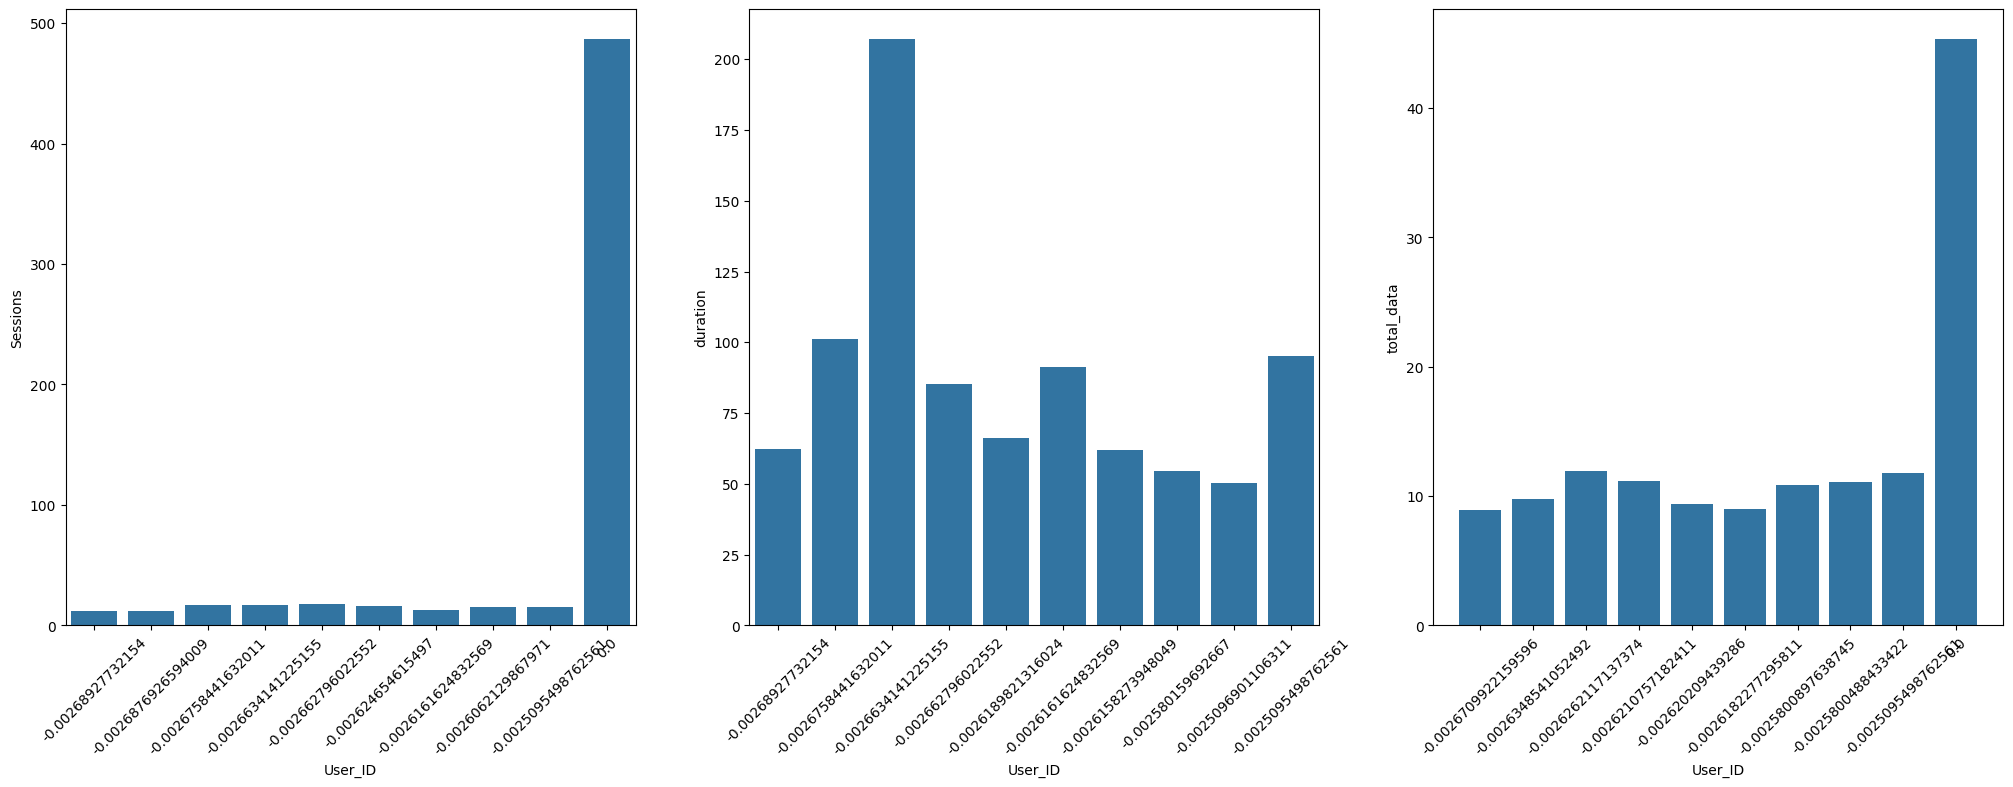

In [21]:
f, axes = plt.subplots(1, 3, figsize=(25, 8))
ax1 = sns.barplot(data=sesssions_df, x='User_ID', orient='v', y='Sessions', ax=axes[0])
ax2 = sns.barplot(data=durations_df, x='User_ID',orient='v', y='duration', ax=axes[1])
ax3 = sns.barplot(data=total_data_df, x='User_ID',orient='v', y='total_data', ax=axes[2])
ax1.set_xticklabels(ax1.xaxis.get_majorticklabels(), rotation=45)
ax2.set_xticklabels(ax2.xaxis.get_majorticklabels(), rotation=45)
ax3.set_xticklabels(ax3.xaxis.get_majorticklabels(), rotation=45)
plt.plot()

Normalize each engagement metric and run a k-means (k=3) to classify customers in three groups of engagement.

In [22]:
from sklearn.preprocessing import Normalizer

def normalizer(df, columns):
    norm = Normalizer()
    # normalize the exponential data with boxcox
    normalized_data = norm.fit_transform(df)

    # plot both together to compare
    fig, ax=plt.subplots(1,2, figsize=(10, 6))
    sns.histplot(df, ax=ax[0])
    ax[0].set_title("Original Data")
    sns.histplot(normalized_data[0], ax=ax[1])
    ax[1].set_title("Normalized data")
    return pd.DataFrame(norm.fit_transform(df), columns=columns)

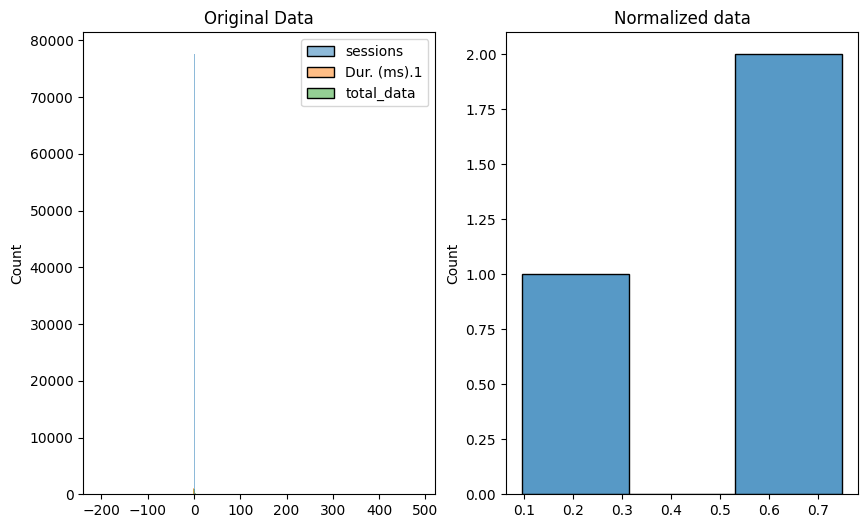

In [23]:
normalized_user_engagement = normalizer(user_engagement, ['sessions', 'Dur. (ms).1', 'total_data'] )

In [24]:
normalized_user_engagement.head()

,sessions,Dur. (ms).1,total_data
0,0.656496,0.096373,0.748148
1,0.439568,0.414970,-0.796605
2,0.911107,0.339230,0.234107
3,0.418740,-0.284431,-0.862413
4,0.483482,-0.515578,0.707407


In [25]:
normalized_user_engagement.describe()

,sessions,Dur. (ms).1,total_data
count,106294.000000,106294.000000,106294.000000
mean,0.647257,-0.053347,0.001139
std,0.194455,0.411023,0.609479
min,0.054857,-0.768590,-0.974943
25%,0.494650,-0.351429,-0.584790
50%,0.650119,-0.127205,-0.000938
75%,0.800719,0.232378,0.588831
max,0.999969,0.997970,0.976403


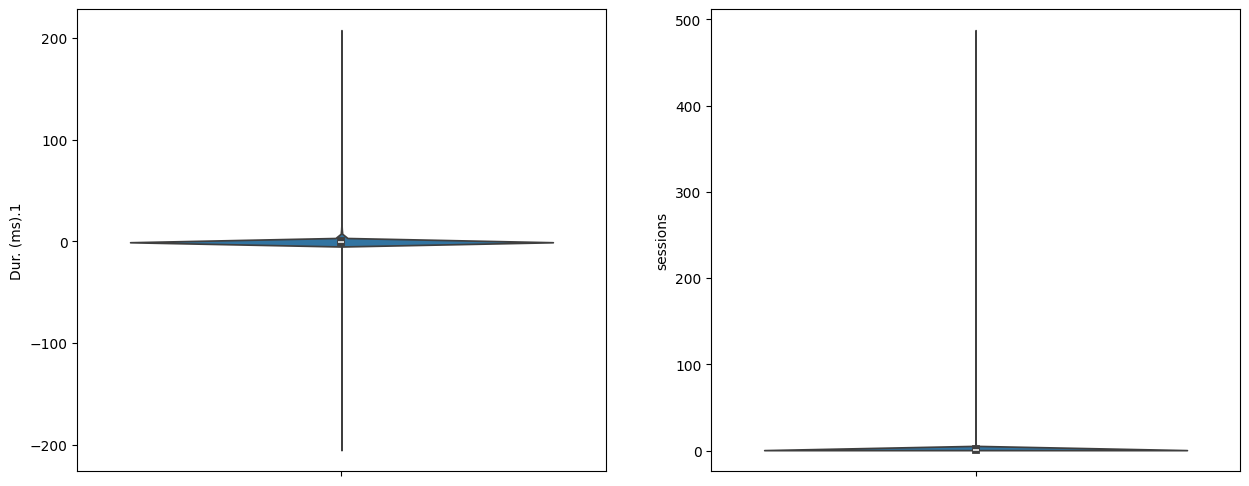

In [26]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.violinplot(y=user_engagement["Dur. (ms).1"])
# sns.boxplot(y=user_engagement["dur._(ms)"], color="red")
plt.subplot(1,2,2)
sns.violinplot(y=user_engagement["sessions"])
# sns.boxplot(y=user_engagement["total_data"])
plt.show()

K-means clustering (K=3)

In [27]:
normalized__eng = normalized_user_engagement.copy()

In [28]:
kmeans = KMeans(init="random",n_clusters=3,n_init=10,max_iter=300,random_state=42)
label = kmeans.fit_predict(normalized__eng)
centroids = kmeans.cluster_centers_

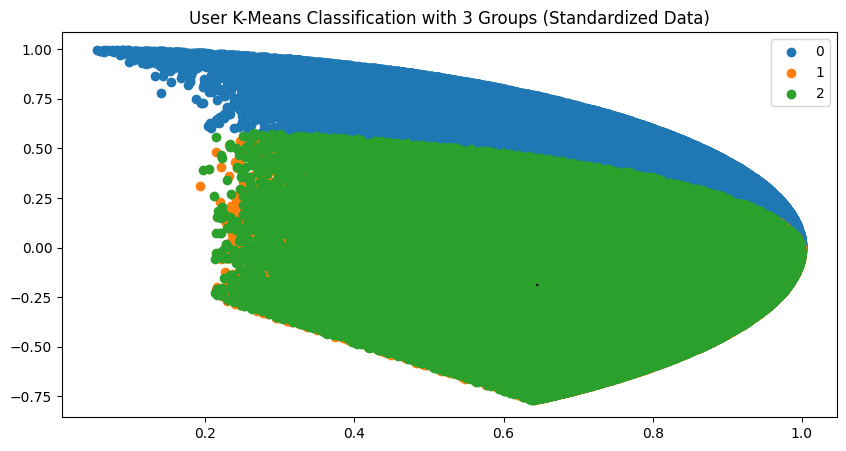

In [29]:
lables_unique = np.unique(label)
#plotting the results:
plt.figure(figsize=(10,5))
plt.title('User K-Means Classification with 3 Groups (Standardized Data)')
for i in lables_unique:
    plt.scatter(normalized__eng[label == i].iloc[:,0] , normalized__eng[label == i].iloc[:,1], marker='o', label = i)
plt.scatter(centroids[:,0] , centroids[:,1],centroids[:,2], marker='x', color = 'black')
plt.legend()
plt.show()

Compute the minimum, maximum, average & total non- normalized metrics for each cluster. Interpret your results visually with accompanying text explaining your findings.

In [30]:
normalized__eng.head()

,sessions,Dur. (ms).1,total_data
0,0.656496,0.096373,0.748148
1,0.439568,0.414970,-0.796605
2,0.911107,0.339230,0.234107
3,0.418740,-0.284431,-0.862413
4,0.483482,-0.515578,0.707407


In [31]:
clustered_Df = pd.DataFrame()
clustered_Df['data_index'] = normalized__eng.index.values
clustered_Df['cluster'] = kmeans.labels_

In [32]:
clustered_Df.cluster.value_counts()

cluster
2    43764
1    43615
0    18915
Name: count, dtype: int64

In [33]:
u_eng = user_engagement.copy()

In [34]:
u_eng.insert(0, 'cluster', kmeans.labels_)
u_eng.head(5)

,cluster,sessions,Dur. (ms).1,total_data
MSISDN/Number,,,,
-0.002692,2,1,0.146799,1.139608
-0.002692,1,1,0.944041,-1.812243
-0.002692,0,1,0.372328,0.256948
-0.002692,1,1,-0.679254,-2.059544
-0.002692,2,2,-2.132773,2.926302


Clusters overview

In [35]:
cluster1 = u_eng[u_eng["cluster"]==0]
cluster1.describe()

,cluster,sessions,Dur. (ms).1,total_data
count,18915.0,18915.000000,18915.000000,18915.000000
mean,0.0,1.481734,1.864340,-0.035703
std,0.0,1.031349,3.448687,1.197416
min,0.0,1.000000,-0.071771,-12.063230
25%,0.0,1.000000,0.673117,-0.609490
50%,0.0,1.000000,1.079752,-0.025891
75%,0.0,2.000000,1.940868,0.557881
max,0.0,18.000000,207.266141,11.948435


In [36]:
cluster2 = u_eng[u_eng["cluster"] == 1]
cluster2.describe()

,cluster,sessions,Dur. (ms).1,total_data
count,43615.0,43615.000000,43615.000000,43615.000000
mean,1.0,1.372303,-0.409404,-1.408655
std,0.0,0.742405,0.697045,1.045521
min,1.0,1.000000,-5.475736,-9.930816
25%,1.0,1.000000,-0.909822,-1.981150
50%,1.0,1.000000,-0.264400,-1.227580
75%,1.0,2.000000,-0.062190,-0.607915
max,1.0,9.000000,4.750893,0.025456


In [37]:
cluster3 = u_eng[u_eng["cluster"] == 2]
cluster3.describe()

,cluster,sessions,Dur. (ms).1,total_data
count,43764.0,43764.000000,43764.000000,43764.000000
mean,2.0,1.374349,-0.397766,1.419291
std,0.0,2.431193,1.209692,1.048985
min,2.0,1.000000,-205.034166,0.004095
25%,2.0,1.000000,-0.901071,0.637188
50%,2.0,1.000000,-0.249916,1.236217
75%,2.0,2.000000,-0.048446,1.988199
max,2.0,487.000000,5.494943,45.368012


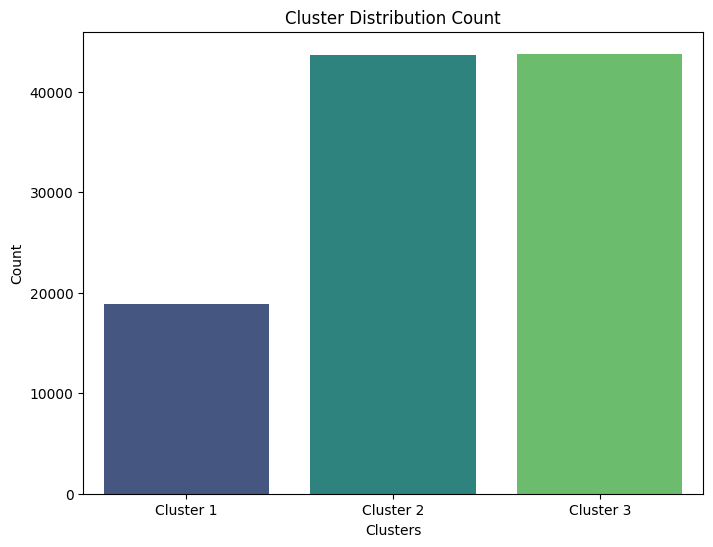

In [38]:
data = [cluster1.sessions.count(), cluster2.sessions.count(), cluster3.sessions.count()]
keys = ['Cluster 1', 'Cluster 2', 'Cluster 3']

# Create a bar plot
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
sns.barplot(x=keys, y=data, palette="viridis")
plt.xlabel("Clusters")
plt.ylabel("Count")
plt.title("Cluster Distribution Count")

# Show the plot
plt.show()


Aggregate user total traffic per application and derive the top 10 most engaged users per application

In [39]:
user_app_usage = df.groupby(
    'MSISDN/Number').agg({ 'social_media': 'sum', 'gaming': 'sum', 'youtube': 'sum',
                           'netflix': 'sum', 'google': 'sum', 'email': 'sum', 'other': 'sum'})

In [40]:
user_app_usage.head()

,social_media,gaming,youtube,netflix,google,email,other
MSISDN/Number,,,,,,,
-0.002692,0.013987,0.147026,-0.188454,0.727900,-1.574015,-0.822344,0.073360
-0.002692,2.307193,0.044451,-1.555082,-1.700644,-1.242335,1.044746,-1.863374
-0.002692,2.080217,0.746006,-0.124888,-0.556604,-2.372450,1.739793,-0.042747
-0.002692,-1.706004,-1.234525,-2.406802,-3.163311,1.471672,-0.964201,-1.256440
-0.002692,-1.468009,-0.345128,-0.480521,0.606266,1.225039,-0.833170,1.965785


Top 10 most engaged users per application

In [41]:
social_media = user_app_usage.nlargest(10, "social_media")['social_media']
gaming = user_app_usage.nlargest(10, "gaming")['gaming']
youtube = user_app_usage.nlargest(10, "youtube")['youtube']
netflix = user_app_usage.nlargest(10, "netflix")['netflix']
google = user_app_usage.nlargest(10, "google")['google']
email = user_app_usage.nlargest(10, "email")['email']
other = user_app_usage.nlargest(10, "other")['other']

In [42]:
social_media_df = pd.DataFrame()
social_media_df['User_ID'] = social_media.index
social_media_df['social_media'] = social_media.values
gaming_df = pd.DataFrame()
gaming_df['User_ID'] = gaming.index
gaming_df['gaming'] = gaming.values
youtube_df = pd.DataFrame()
youtube_df['User_ID'] = youtube.index
youtube_df['youtube'] = youtube.values

netflix_df = pd.DataFrame()
netflix_df['User_ID'] = netflix.index
netflix_df['netflix'] = netflix.values
google_df = pd.DataFrame()
google_df['User_ID'] = google.index
google_df['google'] = google.values
email_df = pd.DataFrame()
email_df['User_ID'] = email.index
email_df['email'] = email.values
others_df = pd.DataFrame()
others_df['User_ID'] = other.index
others_df['other'] = other.values

Top 10 most engaged users per application

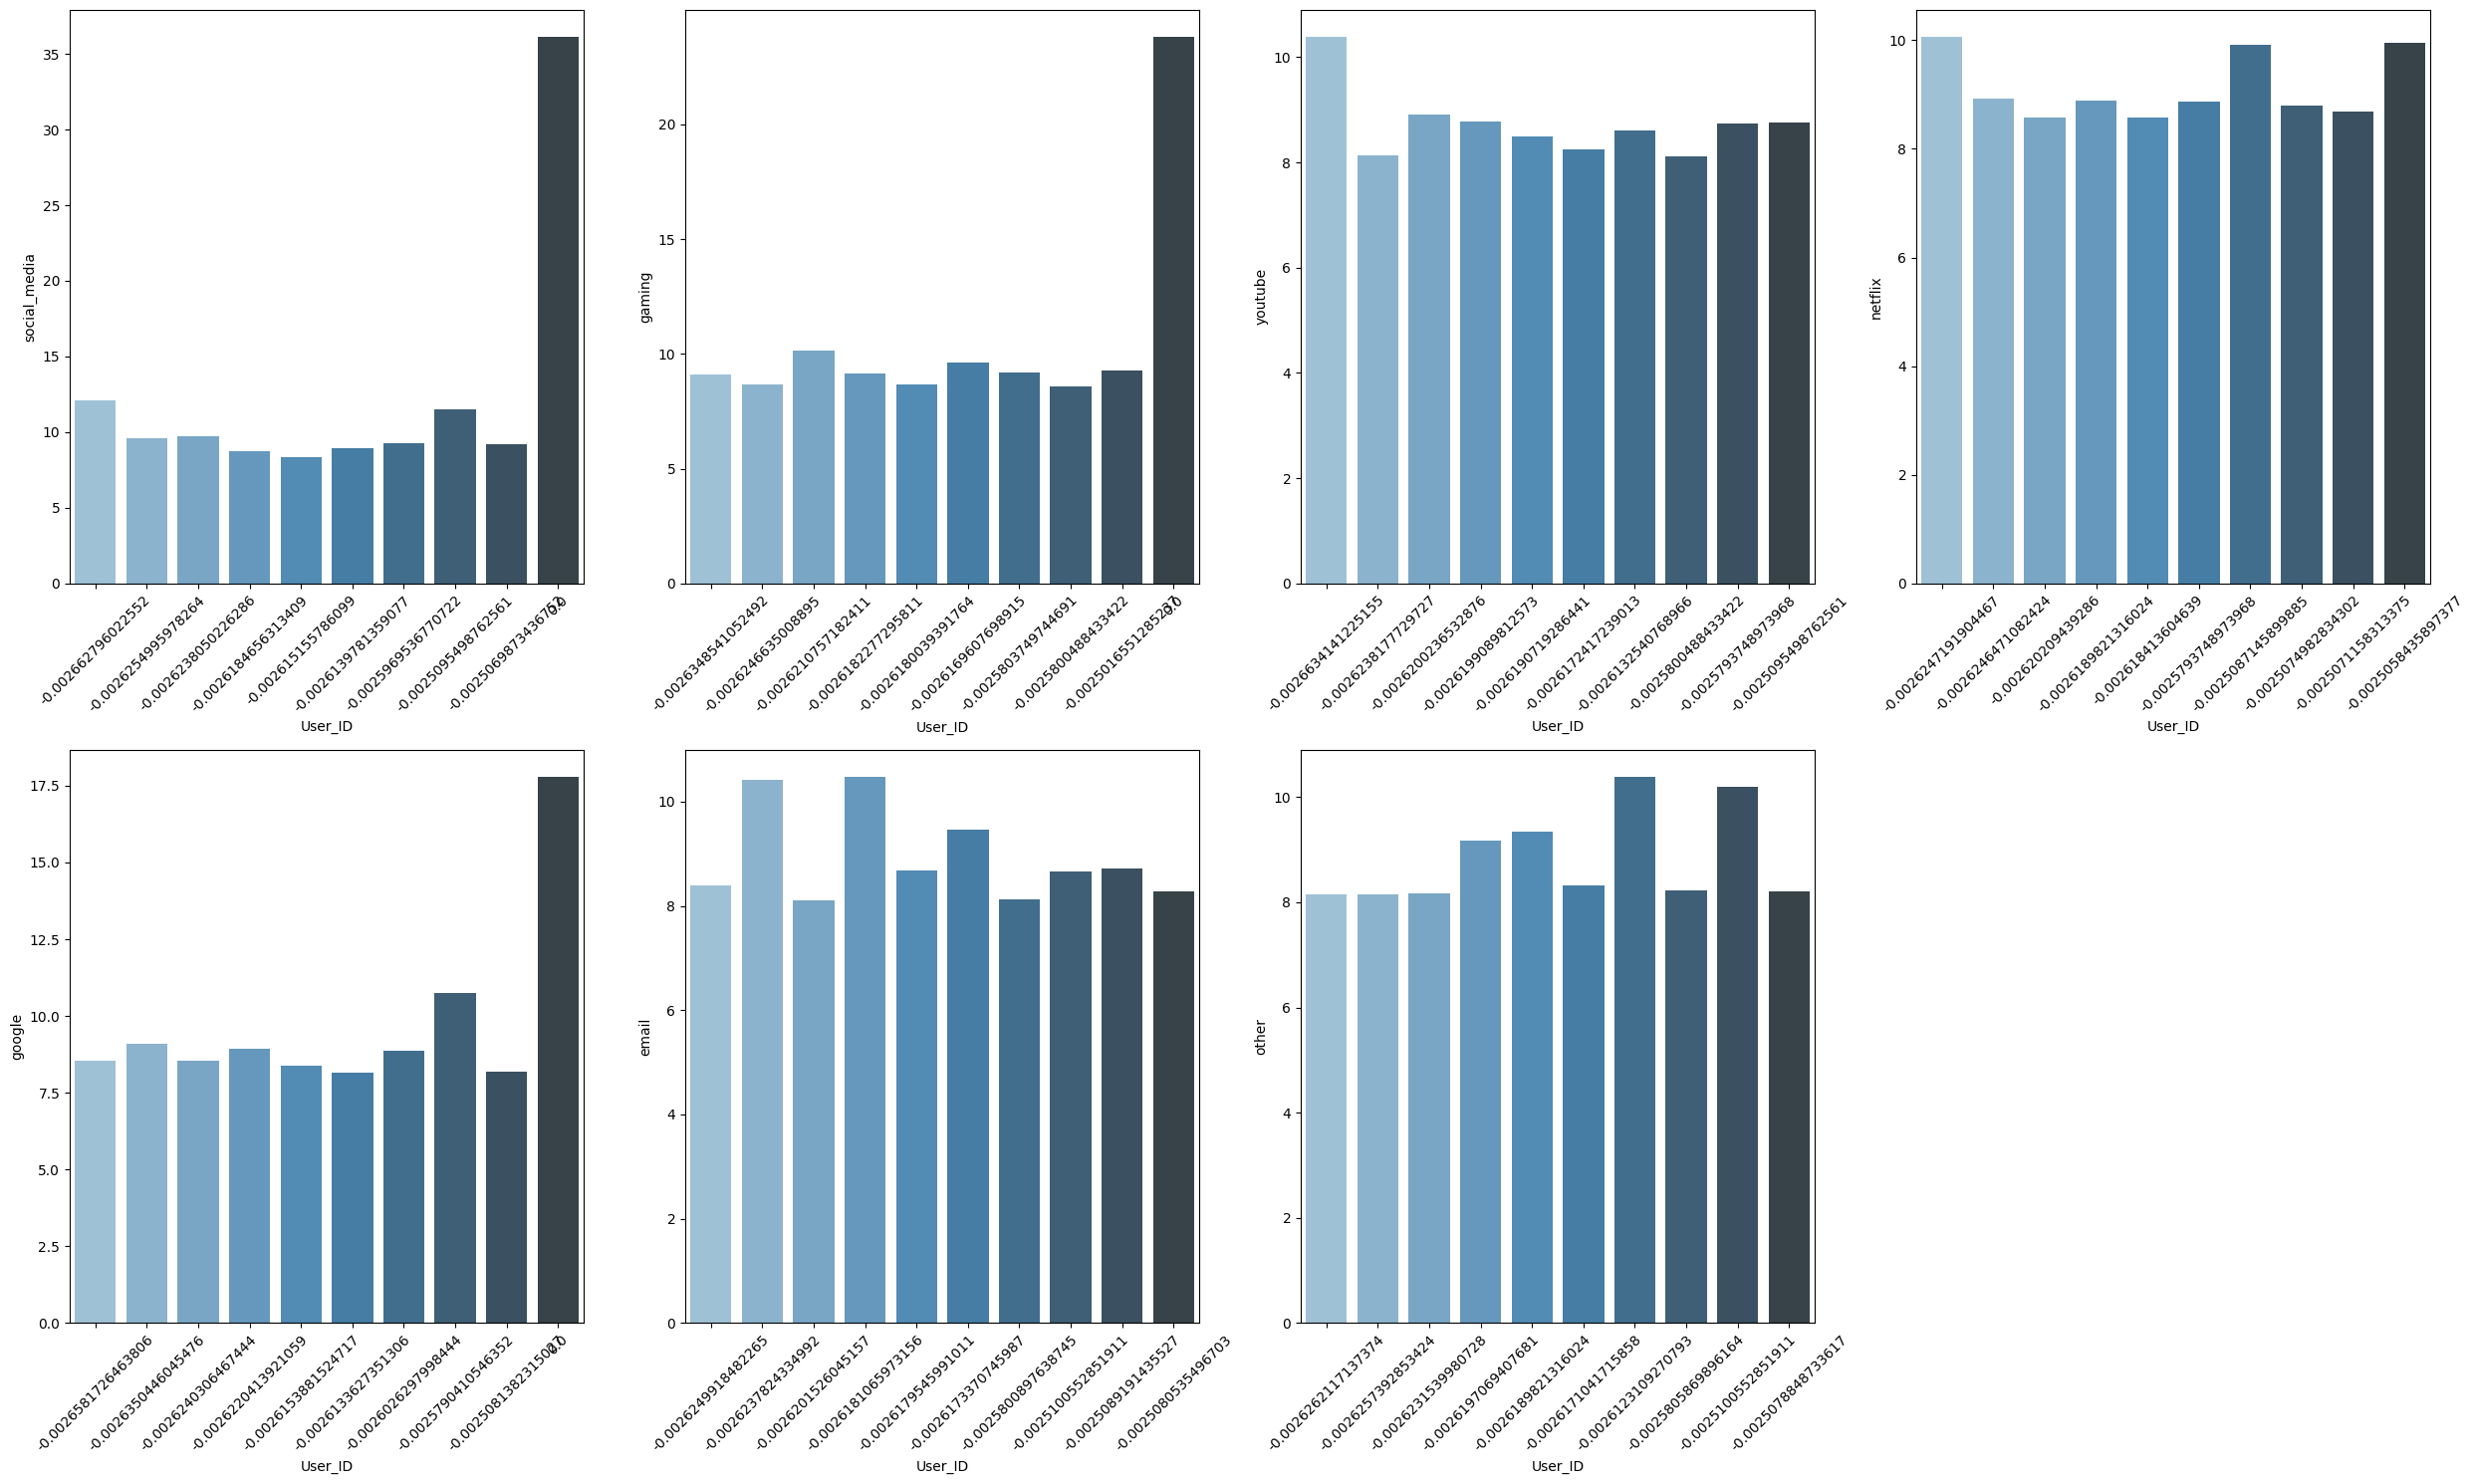

In [43]:
# DataFrames and their respective column names
df_list = [
    (social_media_df, 'social_media'),
    (gaming_df, 'gaming'),
    (youtube_df, 'youtube'),
    (netflix_df, 'netflix'),
    (google_df, 'google'),
    (email_df, 'email'),
    (others_df, 'other')
]

# Create a subplot grid of 2x4 (2 rows and 4 columns)
f, axes = plt.subplots(2, 4, figsize=(25, 15))

# Flatten axes array for easier indexing
axes = axes.flatten()

# Iterate through the dataframes and plot the barplots
for i, (df, column) in enumerate(df_list):
    sns.barplot(data=df, x='User_ID', y=column, ax=axes[i], palette='Blues_d')
    axes[i].set_xticklabels(axes[i].xaxis.get_majorticklabels(), rotation=45)

# Hide the last empty subplot (axes[7])
axes[7].axis('off')

# Display the plot
plt.tight_layout()
plt.show()

Plot the top 3 most used applications using appropriate charts.

In [44]:
top_used_applications = user_app_usage.sum()
top_used_applications.values

array([ 2.17426077e-12, -3.56692453e-12,  8.54072368e-12, -1.15107923e-11,
        1.31592515e-11, -1.10276233e-11, -5.71986902e-12])

In [45]:
top_3_used = top_used_applications.nlargest(3)
top_3_used

google          1.315925e-11
youtube         8.540724e-12
social_media    2.174261e-12
dtype: float64

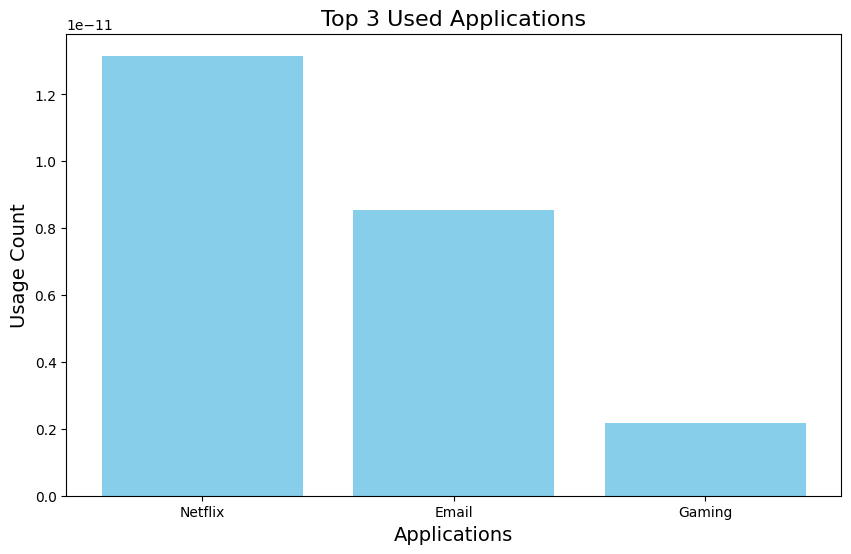

In [46]:
apps = ["Netflix", "Email", "Gaming"]
usage_counts = top_3_used.values

def plot_bar(apps, usage_counts, title, xlabel, ylabel):
    plt.figure(figsize=(10, 6))
    plt.bar(apps, usage_counts, color='skyblue')
    
    # Adding title and labels
    plt.title(title, fontsize=16)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    
    # Show the plot
    plt.show()

# Call the function
plot_bar(apps, usage_counts, "Top 3 Used Applications", "Applications", "Usage Count")

Using k-means clustering algorithm, group users in k engagement clusters based on the engagement metrics

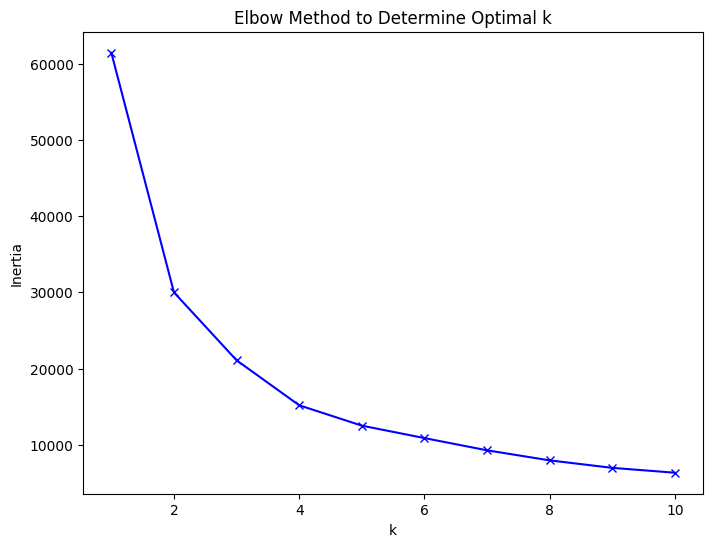

In [47]:
from sklearn.cluster import KMeans

# Determine the best value of k
inertia = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(normalized__eng)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 6))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method to Determine Optimal k')
plt.show()

In [48]:
# Assuming 'inertias' is a list of inertia values for k-means clustering
inertias = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

# Apply the KneeLocator to find the elbow point
kl = KneeLocator(range(1, len(inertias) + 1), inertias, curve="convex", direction="decreasing")

# Get the elbow point
elbow_point = kl.elbow

# Print the elbow point
print("The elbow point is at:", elbow_point)

The elbow point is at: 1


Interpretation

Using the elbow method, the optimal number of cluster is 1, which is the number of cluster I used above in the k-means clustering.